In [1]:
#!/usr/bin/env python
import cv2
import matplotlib
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore') 

#Function for the creation of a 3d matrix
def ThreeD(a, b, c):
    lst = [[ ['0' for col in range(a)] for col in range(b)] for row in range(c)]
    return lst

In [2]:
datasetPath='C:/Users/Lucrezia/Desktop/Internship/MNM_version2-Revision17/Mingle/'# put the path of your video here 
DAY=1 # day number 

In [3]:
#converts a CSV file into an array, returns any array, the array encoded in the CSV file
def openCSV(filename):
    rows = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            rows.append(row)
    arr = np.array(rows)
    return arr

In [16]:
#to count how many people were in a conversation 
def partcounter(numbers): 
    a=' '
    cardinality=0
    for i in numbers:
        if i!=' ' and a==' ':
            cardinality+=1
            a='a'
        else:
            cardinality=cardinality
            a=' '  
    return cardinality

In [5]:
#saving the daily ID of the two participants
def litoint(x):
    val=[]
    val2=[]
    count=0
    for i in x: 
        if i!=' ' and count==0:
            val.append(i)
        elif i!=' ' and count==1:
            val2.append(i)
        else:
            count=1 
    s = [str(integer) for integer in val]
    a_string = "".join(s)
    res = int(a_string)
    s1 = [str(integer) for integer in val2]
    a_string1 = "".join(s1)
    res1 = int(a_string1)
    return([res,res1])

In [6]:
#this function will automaticall give the total ID, as input it needs the daily ID,the numer of the day, and the path
def realID(s,day,datasetPath):
    cont=0
    # LABELS
    try:
        filename1 = datasetPath+'manual_annotations/PARTICIPANTS.csv'
        labels1 = openCSV(filename1)
    except FileNotFoundError:
        filename1 = datasetPath+'manual_annotations/_PARTICIPANTS.csv'
        labels1 = openCSV(filename1).astype(np.int64)
    for i in labels1:
        cont+=1
        if int(i[0])==DAY:
            if int(i[1])==s:
                return(cont)

In [7]:
#dividing the labels, frames is the history we want to keep in the labels and in the x data, if we want to have a memory of 2 frame it will be 2
#in this case we want to use it with SVM,XGBoost,Random Forest, so we will use 1.
#we iterate from that number to the all length, taking in to account to divide each conversation separatly and then append all the data togheter.
def divisory(y,frames):
    lista=[]
    count=0
    for i in range((frames),len(y)):  #we will divide the conversation frames by frames, so we will have to start at frames till the end. 
        lista.append([y[i]])
        count+=1
    lista.append([3])
    return(lista)

In [8]:
#dividing the xdata, frames is the history we want to keep in the labels and in the x data, if we want to have a memory of 2 frame it will be 2
#in this case we want to use it with SVM,XGBoost,Random Forest, so we will use 1.
#we iterate from that number to the all length, taking in to account to divide each conversation separatly and then append all the data togheter.
def divisorx(x,frames):
    lista=[]
    for i in range(0,len(x)-(frames-1)): #we will divide the conversation frames by frames, so we will have to stop frames -1 before the end. 
        temp=[]
        for j in range(0,frames):
            temp.append(x[i+(j)])
        lista.append(temp)
    return(lista)

In [9]:
# LABELS
try:
    filename = datasetPath+'manual_annotations/LABELS.csv'
    labels = openCSV(filename).astype(np.int64)
except FileNotFoundError:
    filename = datasetPath+'manual_annotations/_LABELS.csv'
    labels = openCSV(filename).astype(np.int64)
print("LABELS array shape =", labels.shape)

LABELS array shape = (36000, 828)


In [10]:
N,M= labels.shape
dataset=ThreeD(9, int(M/9), int(N))
for i in range (0,N):
    for j in range(0,M):
        dataset[i][int(j/9)][j%9]=(labels[i][j])

In [11]:
# reading the file with the conversation, containing the persons involved and the initial and final time
try:
    filename1 = datasetPath+'manual_annotations/F-formationsGT/Day'+str(DAY)+'.csv'
    labels1 = openCSV(filename1)
except FileNotFoundError:
    filename1 = datasetPath+'manual_annotations/F-formationsGT/Day'+str(DAY)+'.csv'
    labels1 = openCSV(filename1).astype(np.int64)
print("LABELS array shape =", labels1.shape)
M1,N1=labels1.shape

LABELS array shape = (69, 5)


In [12]:
M1,N1=labels1.shape
liscoupl=[]
for i in range(0,M1):
    if i!=0:
        if partcounter(labels1[i][0])==2: #couples, if more litoint needs to be modify to accept more persons
            s=litoint(labels1[i][0])
            k=[]
            k.append(realID(s[0],DAY,datasetPath))#saving real ID person1 and real ID person2
            k.append(realID(s[1],DAY,datasetPath))
            liscoupl.append([k,int(labels1[i][3]),int(labels1[i][4])])#appending ID participants and initial final frame

In [13]:
#label creation
speaker=[]
spdata=[]
for j in range(0,len(liscoupl)):
        temp=[]
        for i in range (0,N):
            personid1 = liscoupl[j][0][0]-1
            personid2 = liscoupl[j][0][1]-1
            if i>liscoupl[j][1] and i<liscoupl[j][2]:
                if dataset[i][personid1][3]==1 and dataset[i][personid2][3]==0:
                    temp.append(0)
                    spdata.append(0)
                elif dataset[i][personid1][3]==0 and dataset[i][personid2][3]==1:
                    temp.append(1)
                    spdata.append(1)
                elif dataset[i][personid1][3]==0 and dataset[i][personid2][3]==0:
                    temp.append(3)
                    spdata.append(3)
                else: 
                    temp.append(2)
                    spdata.append(2)
        temp1=divisory(temp,1)
        speaker.extend(temp1)

In [14]:
import sys
import csv
maxInt = sys.maxsize

while True:
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
tempo=-1
with open('labeldyadsalldayprova.csv', 'w',newline='') as csvfile: #create a csv file, may be usefull if you use colab
    biglist=[]
    biglist2=[]
    writer = csv.writer(csvfile)
    for j in range(0,len(liscoupl)):
        listprov=[]
        for i in range (0,N):
            personid1 = liscoupl[j][0][0]-1
            personid2 = liscoupl[j][0][1]-1
            if i>liscoupl[j][1] and i<liscoupl[j][2]:
                tempo+=1
                #best 3 features
                listprov.append([dataset[i][personid1][3],dataset[i][personid1][4],dataset[i][personid1][5],dataset[i][personid2][3],dataset[i][personid2][4],dataset[i][personid2][5]])
                #best 4 feature, except for talking
                #listprov.append([dataset[i][personid1][2],dataset[i][personid1][4],dataset[i][personid1][5],dataset[i][personid2][2],dataset[i][personid2][4],dataset[i][personid2][5]])
                #all features except for speaking
                #listaprov.append([dataset[i][personid1][0],dataset[i][personid1][1],dataset[i][personid1][2],dataset[i][personid1][4],dataset[i][personid1][5],dataset[i][personid1][6],dataset[i][personid1][7],dataset[i][personid2][0],dataset[i][personid2][1],dataset[i][personid2][2],dataset[i][personid2][4],dataset[i][personid2][5],dataset[i][personid2][6],dataset[i][personid2][7]])    
                if (dataset[i][personid1][3]==1 and dataset[i][personid2][3]==0) and spdata[tempo]==0:
                    pass
                elif (dataset[i][personid1][3]==0 and dataset[i][personid2][3]==1) and spdata[tempo]==1:
                    pass
                elif (dataset[i][personid1][3]==0 and dataset[i][personid2][3]==0) and spdata[tempo]==3:
                    pass
                elif (dataset[i][personid1][3]==1 and dataset[i][personid2][3]==1) and spdata[tempo]==2: 
                    pass
                else: 
                    print('ERRORE')
                    print(dataset[i][personid1][3])
                    print(dataset[i][personid2][3])
                    print(speaker[tempo])
        biglist2.extend(listprov)
        lista=divisorx(listprov,1)
        biglist.extend(lista)  
        writer.writerow([listprov])

In [15]:
#embedding and division of the dataset
sp1=np.array(speaker)
x=np.array(biglist)#.astype(np.float32)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X_train, y_train = np.array(x[:43974]), np.array(sp1[:43974])#70%#
X_test, y_test = np.array(x[43974:]), np.array(sp1[43974:])#10%

X_train = X_train.reshape(X_train.shape[0], (X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape(X_test.shape[0], (X_test.shape[1]*X_test.shape[2]))

y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1])

print('dataset complete: ',x.shape)
print('label complete: ',sp1.shape)
print('dataset train: ',X_train.shape)
print('label train: ',y_train.shape )
print('dataset test: ',X_test.shape)
print('label test: ',y_test.shape)

dataset complete:  (76596, 1, 6)
label complete:  (76596, 1)
dataset train:  (43974, 6)
label train:  (43974,)
dataset test:  (32622, 6)
label test:  (32622,)


In [23]:
import time 
start = time.time()
from sklearn.svm import SVC
kernel=['linear','rbf','sigmoid','poly']
from sklearn.metrics import accuracy_score

clf = SVC(kernel='rbf',decision_function_shape='ovo')
clf = clf.fit(X_train,y_train )
tt=clf.predict(X_train)
test= clf.predict(X_test)
print('poly')
print('train: ',(accuracy_score(y_train, tt)))
print('test: ',accuracy_score(y_test, test))

'''
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing='NaN',
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
test=model.predict(X_test)
tt=model.predict(X_train)
print(accuracy_score(y_train, tt))
print(accuracy_score(y_test, test))              
              
              
'''
'''
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
test=clf.predict(X_test)
tt=clf.predict(X_train)
print(accuracy_score(y_train, tt))
print(accuracy_score(y_test, test))
'''
end = time.time()
print(end - start)

poly
train:  0.9689707554464001
test:  0.9630175954877077
8.276055097579956


'\nfrom sklearn.ensemble import RandomForestClassifier\nclf = RandomForestClassifier()\nclf.fit(X_train, y_train)\nval=clf.predict(X_val)\ntest=clf.predict(X_test)\ntt=clf.predict(X_train)\nprint(accuracy_score(y_train, tt))\nprint(accuracy_score(y_val, val))\nprint(accuracy_score(y_test, test))\n'

C:\Users\Lucrezia\AppData\Local\Temp/ipykernel_14532/1498129022.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Confmatrixsvmallnos',bbox='tight_layout',dpi=100)


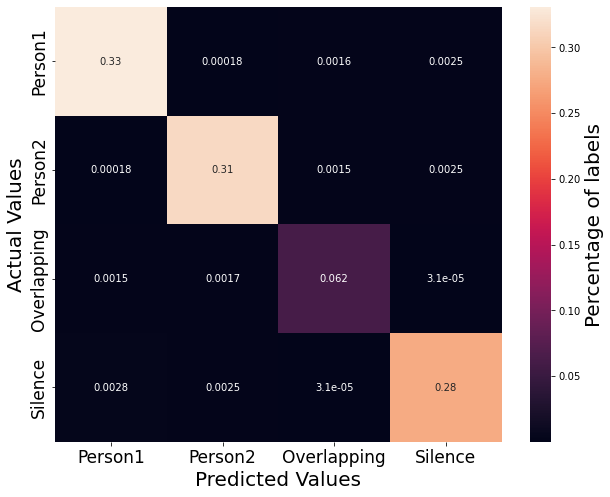

In [17]:
cm = confusion_matrix(y_test, test,normalize='all')
cm_df = pd.DataFrame(cm,
                     index = ['Person1','Person2','Overlapping','Silence'], 
                     columns = ['Person1','Person2','Overlapping','Silence'])
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
ax=sns.heatmap(cm_df, annot=True)
ax.collections[0].colorbar.set_label('Percentage of labels',fontsize=20)
plt.ylabel('Actual Values',fontsize=20)
plt.xlabel('Predicted Values',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('Confmatrixsvmallnos',bbox='tight_layout',dpi=100)
plt.show()

In [24]:
c=0
b=(len(test))
cont2=0
conpred2=0
for i in range(0,b):
    if test[i]==2:
        conpred2+=1
    if y_test[i]==2:
        cont2+=1
    if test[i]!=y_test[i]:
        c+=1
print('Percentage correct pred: ',(b-c)*(100/b))

Percentage correct pred:  96.30175954877076
